In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
passengers = pd.read_excel('passengers.xlsx')
routes = pd.read_excel('routes_info.xlsx')

In [3]:
passengers.info()
passengers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39202 entries, 0 to 39201
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          39202 non-null  datetime64[ns]
 1   route_number  39202 non-null  object        
 2   passengers    39202 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 918.9+ KB


,date,route_number,passengers
0,2020-01-01,ТМ2,639
1,2020-01-01,ТМ4,1558
2,2020-01-01,ТМ5,7870
3,2020-01-01,ТМ6,990
4,2020-01-01,ТМ7,1973


In [4]:
passengers['year_month'] = passengers['date'].dt.strftime('%Y-%m')

In [5]:
routes.info()
routes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   route_number      88 non-null     object 
 1   route_name        88 non-null     object 
 2   length_km         88 non-null     float64
 3   type              88 non-null     object 
 4   class             88 non-null     object 
 5   units_quantity    84 non-null     float64
 6   reserve_quantity  84 non-null     float64
 7   units_age         77 non-null     object 
 8   length_type       88 non-null     object 
dtypes: float64(3), object(6)
memory usage: 6.3+ KB


,route_number,route_name,length_km,type,class,units_quantity,reserve_quantity,units_age,length_type
0,1,Микрорайон Садовый – станция Пермь-II,10.20,автобус,большой,19.0,2.0,Не старше 7 лет,10-20 км
1,2,Станция Пермь-II – станция Пермь-I,5.20,автобус,большой,6.0,1.0,Не старше 5 лет,< 10 км
2,3,Станция Пермь-I – Дворец творчества юных (12) ...,10.80,автобус,большой,17.0,2.0,Не старше 7 лет,10-20 км
3,4,Дворец спорта «Молот» – микрорайон Нагорный,13.55,автобус,большой,17.0,2.0,Не старше 7 лет,10-20 км
4,5,Комсомольская площадь – НПО «Биомед» – микрора...,9.60,автобус,малый и средний,6.0,1.0,Не старше 5 лет,< 10 км


### Исследуем данные

Определим период, данными за который мы располагаем и сколько пассажиров было перевезено общественным транспортом за это время:

In [6]:
print(f"{passengers['date'].min()} - {passengers['date'].max()}")

2020-01-01 00:00:00 - 2021-05-31 00:00:00


In [7]:
passengers['passengers'].sum()

231293961

Итак, оперируем данными за 17 месяцев, включая допандемийные январь и февраль 2020.

За этот период пермяки воспользоваись общественным транспортом **231,3 млн раз**

Оценим динамику изменения количества перевезенных пассажиров всеми видами общественного транспорта:

In [8]:
all_routes = passengers.groupby(['year_month']).agg({'passengers': 'sum'})
all_routes.columns = ['count_of_passengers']
all_routes = all_routes.reset_index()

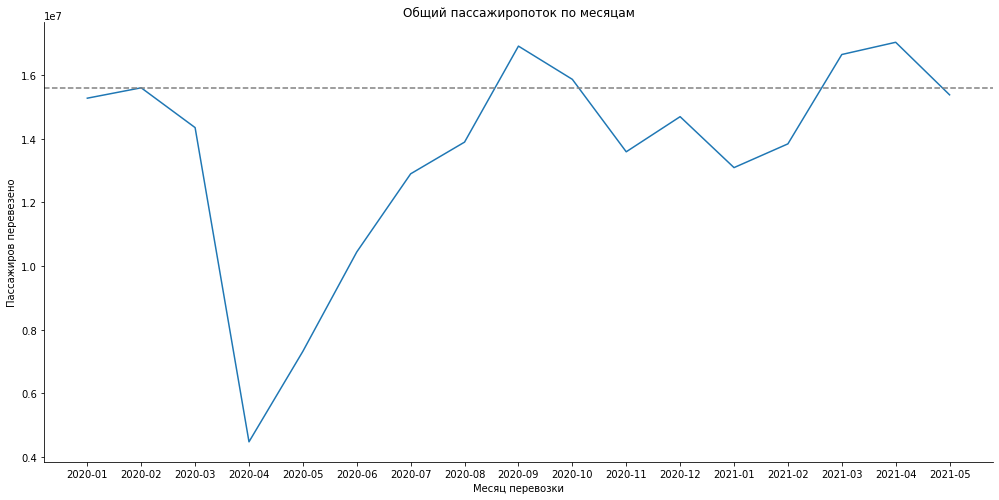

In [9]:
sns.relplot(x='year_month', y='count_of_passengers', data=all_routes, height=7, aspect=2, kind='line')
plt.title('Общий пассажиропоток по месяцам')
plt.ylabel('Пассажиров перевезено')
plt.xlabel('Месяц перевозки')
plt.axhline(y=15601129, color='gray', linestyle='--');

Видим, что показатели на уровне февраля 2020 (**15,6 млн пассажиров**) были достигнуты в последующие периоды только в 4 месяцах. Сентябрь-октябрь 2020 и март-апрель 2021. Стоит учесть, что начиная с июня 2020 бесплатные пересадки были внедрены на большей части маршрутов, а чуть позже и на всех маршрутах.

То есть, можем говорить о том, что пассажиропоток после локдауна в апреле 2020 до конца не восстановился.

Однако особенностью Перми является большая протяженность вдоль Камы и ряд маршрутов, которые перевозят пассажиров на большие расстояния. В основном эти маршруты связывают центр города с отдаленными айонами, в том числе находящимися на противоположном берегу.

Разделим все маршруты на следующие категории по протяженности:
- до 10 км;
- 10-20 км;
- более 20 км.

Посмотрим на динамику перевозок в разрезе протяженности маршрутов:

In [10]:
routes.groupby('length_type').agg({'route_name': 'count'})

,route_name
length_type,
10-20 км,46
< 10 км,21
> 20 км,21


Самая распространенная протяженность для маршрутов общественного транспорта - 10-20 км. Около четверти приходится на дистанции < 10 км и > 20 км соответственно.

Оценим пассажиропоток маршрутов общественного транспорта в зависимости от дины маршрута.

In [11]:
routes_by_length = passengers.groupby(['year_month', 'route_number']).agg({'passengers': 'sum'}).sort_values(by='passengers', ascending=False).reset_index()

In [12]:
routes_by_length =  routes_by_length.merge(routes, how='inner', on='route_number')

In [13]:
passengers_by_length = routes_by_length.groupby(['year_month', 'length_type']).agg({'passengers': 'sum'}).sort_values(by='passengers', ascending=False)
passengers_by_length.columns = ['count_of_passengers']
passengers_by_length = passengers_by_length.reset_index()

In [14]:
length_ratio = passengers_by_length.groupby('length_type').agg({'count_of_passengers': 'sum'})
length_ratio['ratio'] = length_ratio['count_of_passengers'] / length_ratio['count_of_passengers'].sum()
length_ratio

,count_of_passengers,ratio
length_type,,
10-20 км,137856349,0.596210
< 10 км,25691941,0.111114
> 20 км,67672895,0.292676


Маршруты средней протяженности перевозят 59,6% пассажиров, 29,2% приходится на длинные маршруты и 11,1% - на короткие.

In [15]:
passengers_by_length[passengers_by_length['year_month'] == '2020-02']

,year_month,length_type,count_of_passengers
0,2020-02,10-20 км,10278397
28,2020-02,> 20 км,3629731
38,2020-02,< 10 км,1693001


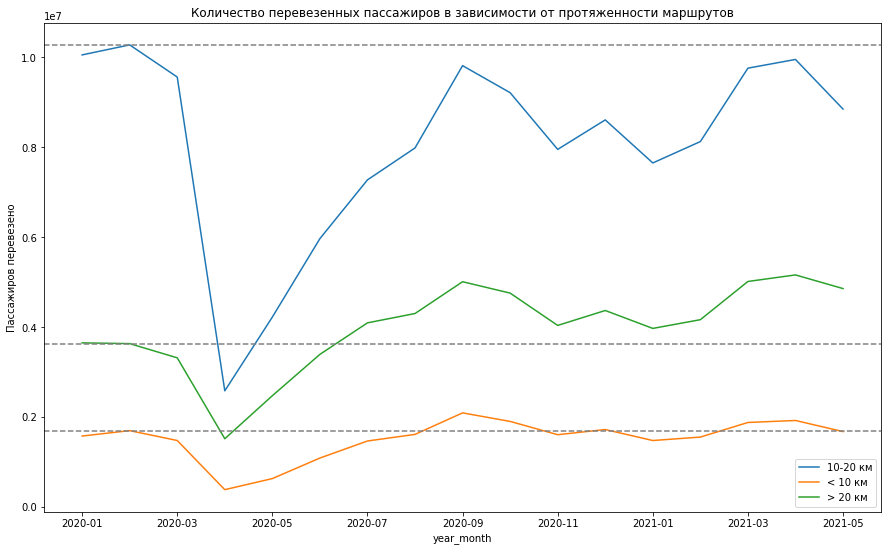

In [16]:
passengers_by_length = passengers_by_length.pivot_table(index='year_month', columns='length_type', values='count_of_passengers', aggfunc='sum')
fig, ax = plt.subplots(figsize=[15, 9])
passengers_by_length.plot(ax=ax)
plt.title('Количество перевезенных пассажиров в зависимости от протяженности маршрутов')
plt.ylabel('Пассажиров перевезено')
plt.legend(loc='lower right')
plt.axhline(y=10278397, color='gray', linestyle='--')
plt.axhline(y=3629731, color='gray', linestyle='--')
plt.axhline(y=1693001, color='gray', linestyle='--');
plt.show()


Можно утверждать, что просадку в пассажиропотоке дают маршруты протяженностью 10-20 км. Пассажиропоток на них не восстановился до показателей февраля 2020.

В то же время видим, что короткие маршруты восстановились к сентябрю 2020 и с тех пор пассажиропоток на них стабилен.

Самую же интересную динамику можем наблюдать для длинных маршрутов. Для них характерна не такая большая просадка и быстрое восстановление пассажиропотока. Уже в июле 2020 пассажиров было перевезено больше, чем в допандемийном феврале. С тех пор количество перевезенных пассажиров не опускается ниже допандемийных значений.
Можно связать это с отсутствием альтернативных вариантов перемещения по городу за сравнимые с автобусом деньги.

Оценим количество пассажиров, перевезенных каждым маршрутом и долю маршрута в структуре перевозок

In [17]:
sum_passengers = passengers.groupby('route_number').agg({'passengers': 'sum'}).sort_values(by='passengers', 
                                                                                   ascending=False).reset_index()
sum_passengers['ratio'] = sum_passengers['passengers'] / sum_passengers['passengers'].sum()

In [18]:
sum_passengers.head(10)

,route_number,passengers,ratio
0,77,12188496,0.052697
1,27,10019027,0.043317
2,14,9762246,0.042207
3,ТМ11,8821483,0.038140
4,36,8649325,0.037395
5,ТМ5,7300348,0.031563
6,1,6896268,0.029816
7,20,6872419,0.029713
8,50,6301833,0.027246
9,10,6016342,0.026012


В **ТОП-10** маршрутов по перевезенным пассажирам **2 трамвайных маршрута**. Лидером же с существенным отрывом является маршрут **№77**, соединяющий центр города с отдаленными районами на левом берегу Камы.

Оценим долю, на которую приходится пассажиропоток 20 самых популярных маршрутов:

In [19]:
sum_passengers.head(20)['passengers'].sum() / sum_passengers['passengers'].sum()

0.5796716542893223

Итак, 20 маршрутов из 88 (**22,7%**) перевезли **57,8%** пассажиров. Рассмотрим более детально динамику пассажиропотока маршрутов ТОП-10 и ТОП11-20.

In [20]:
top_10 = sum_passengers['route_number'].head(10)
top_11_20 = sum_passengers.loc[(sum_passengers.index > 9) & (sum_passengers.index <= 19)]['route_number']

In [21]:
top10_routes = passengers.query('route_number in @top_10')
top10_routes = top10_routes.groupby(['year_month', 'route_number']).agg({'passengers': 'sum'}).sort_values(by='passengers', 
                                                                                                           ascending=False)
top10_routes.columns = ['count_of_passengers']
top10_routes = top10_routes.reset_index()

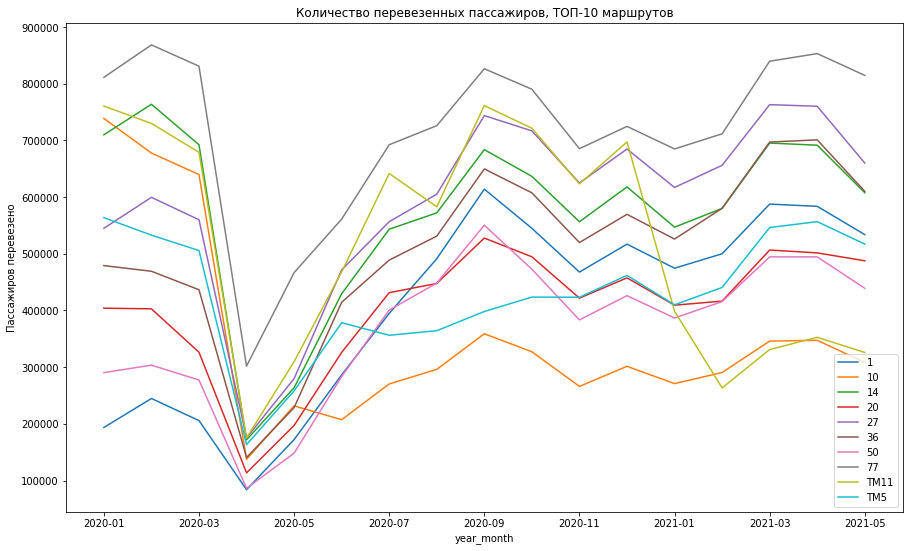

In [22]:
top10_routes_passengers = top10_routes.pivot_table(index='year_month', columns='route_number', values='count_of_passengers', aggfunc='sum')
fig, ax = plt.subplots(figsize=[15, 9])
top10_routes_passengers.plot(ax=ax)
plt.title('Количество перевезенных пассажиров, ТОП-10 маршрутов')
plt.ylabel('Пассажиров перевезено')
plt.legend(loc='lower right');
plt.show()


В ТОП10 маршрутов можно выделить несколько, пассажиропоток на которых отличается от общей динамики.

Автобус №27 восстанавливается по пассажиропотоку к июлю 2020 и сохраняет позиции. Вероятно это связано с отменой маршрута №13, который частично дублирует 27.

Автобус №10 после сокращения маршрута до Октябрьской площади теряет порядка 40% пассажиров по сравнению с февралем 2020.

Автобус №36 после смены конечной точки маршрута на "Ироничную компанию" наращивает пассажиропоток. При этом лидер рейтинга - автобус 77, несмотря на смены конечной на ул. Мильчакова практически восстанавливает количество перевезенных пассажиров. Эту рокировку однозначно можно занести в актив разработчиков новой маршрутной сети.

Автобус №50 начиная с июля показывает рост пассажиропотока относительно периода до пандемии. Однако причины здесь на поверхности. С 1 июня 2020 мкрн Крохалева лишился автобусов №66 и №43, ранее с ул. Лодыгина "ушли" троллейбусы. Единственной альтернативой для жителей ряда кварталов остался автобус №50 и трамваи 5 и 8.

И, наконец, трамвай №11. В сумме по перевезенным пассажирам он находится на 4 месте. Однако маршрут трамвая в январе 2021 был перенаправлен на Пермскую ярмарку в связи с ремонтом путей на ул. Уральской. До этого периода 11 трамвай перевозил количество пассажиров, сравнимое с автобусом №27 и мог бы занять 2-3 место по количеству перевезенных пассажиров.

Вероятно, далеко не каждый крупный город России может похвастаться фактом, что в ТОП3 маршрутов по количеству перевезенных пассажиров находится экологичный вид транспорта, которому, к тому же, и пробки ни по чем.

Рассмотрим влияние отмены ряда маршрутов и появления альтернативных вариантов на примере нескольких микрорайонов. 

Мкр Крохалева - наиболее яркий пример изменений, связанных с проведением транспортной реформы. Были отменены маршруты 43 и 66, взамен для связи с центром города был восстановлен маршрут 45.

Также было изменено, а затем восстановлено направление автобуса 63, с той лишь разницей, что внутри микрорайона он стал следовать по ул. Солдатова.

In [23]:
krohaleva = ['43', '45', '62', '63', '66', '50', '56', '57', 'ТМ5', 'ТМ8']
krohaleva_routes = passengers.query('route_number in @krohaleva')
krohaleva_routes = krohaleva_routes.groupby(['year_month', 'route_number']).agg({'passengers': 'sum'}).sort_values(by='passengers', ascending=False)
krohaleva_routes.columns = ['count_of_passengers']
krohaleva_routes = krohaleva_routes.reset_index()

In [24]:
sum_krohaleva_routes = krohaleva_routes.groupby('year_month').agg({'count_of_passengers': 'sum'}).reset_index()

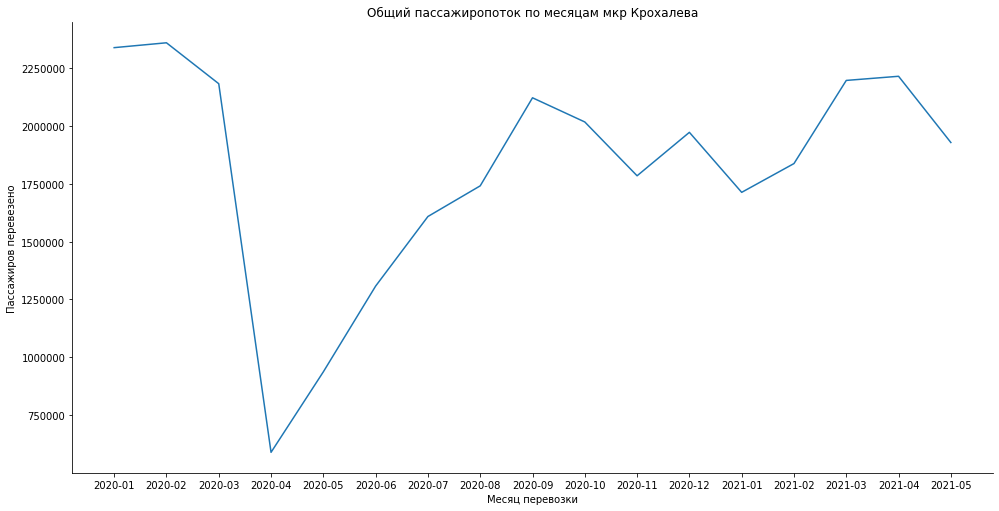

In [25]:
sns.relplot(x='year_month', y='count_of_passengers', data=sum_krohaleva_routes, height=7, aspect=2, kind='line')
plt.title('Общий пассажиропоток по месяцам мкр Крохалева')
plt.ylabel('Пассажиров перевезено')
plt.xlabel('Месяц перевозки');

Итак, общий пассажиропоток в рамках микрорайона не восстановился до допандемийных значений. Посмотри данные в разбивке по маршрутам.

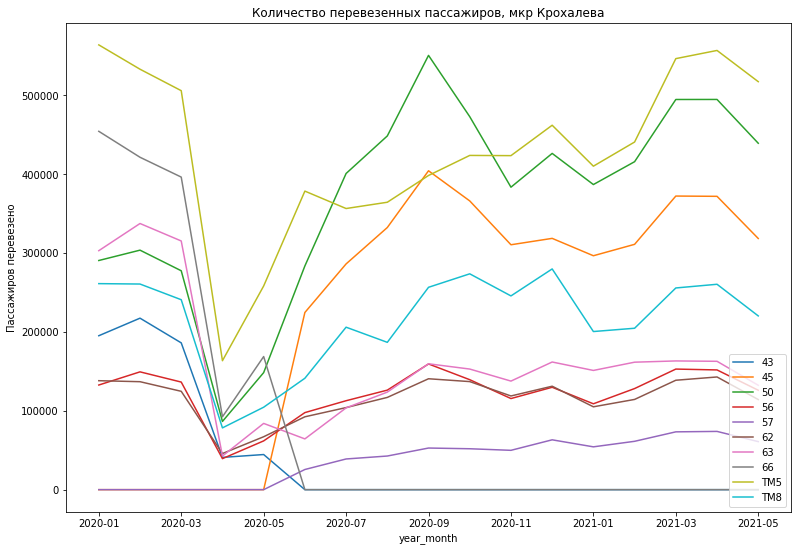

In [26]:
krohaleva_routes_passengers = krohaleva_routes.pivot_table(index='year_month', columns='route_number', values='count_of_passengers', aggfunc='sum')
krohaleva_routes_passengers.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=[13, 9])
krohaleva_routes_passengers.plot(ax=ax)
plt.title('Количество перевезенных пассажиров, мкр Крохалева')
plt.ylabel('Пассажиров перевезено')
plt.legend(loc='lower right');
plt.show()

Для жителей довольно большой части микрорайона единственным способом уехать в центр города стал автобус №50, по которому можно отметить рост пассажиропотока. Но при более детальном рассмотрении можно сделать вывод, что на него ушли пассажиры маршрута 63, который перевозит в 2-2,5% раза меньше пассажиров, чем в феврале 2020.

Автобусы 56, 57 и 62 - локальные истории, связывающие друг с другом соседние микрорайоны без заезда в центр. Пассажиропоток на них низкий, но стабильный. Можно говорить о возврате к допандемийным показателям.

Трамвай №8 практически восстановился по количеству перевезенных пассажиров, динамика соответствует общегородской.

Интересно, что на цифры зимы 2020 вышел и трамвай №5, который ктому же является самым популярным видом транспорта для жителей микрорайона начиная с ноября 2020. Здесь, вероятно, можно говорить о том, что пермяки не хотят стоять в пробках на ул. Куйбышева в утренний и вечерний час пик и предпочитают трамваи.

In [27]:
zagarie = ['16', '10', '51', '74', 'ТМ6']
zagarie_routes = passengers.query('route_number in @zagarie')
zagarie_routes = zagarie_routes.groupby(['year_month', 'route_number']).agg({'passengers': 'sum'}).sort_values(by='passengers', ascending=False)
zagarie_routes.columns = ['count_of_passengers']
zagarie_routes = zagarie_routes.reset_index()

In [28]:
sum_zagarie_routes = zagarie_routes.groupby('year_month').agg({'count_of_passengers': 'sum'}).reset_index()

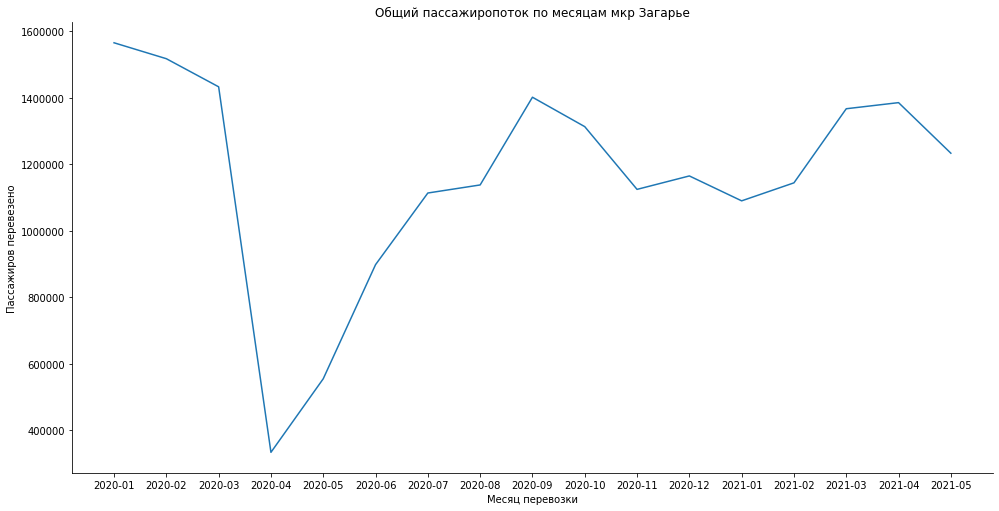

In [29]:
sns.relplot(x='year_month', y='count_of_passengers', data=sum_zagarie_routes, height=7, aspect=2, kind='line')
plt.title('Общий пассажиропоток по месяцам мкр Загарье')
plt.ylabel('Пассажиров перевезено')
plt.xlabel('Месяц перевозки');

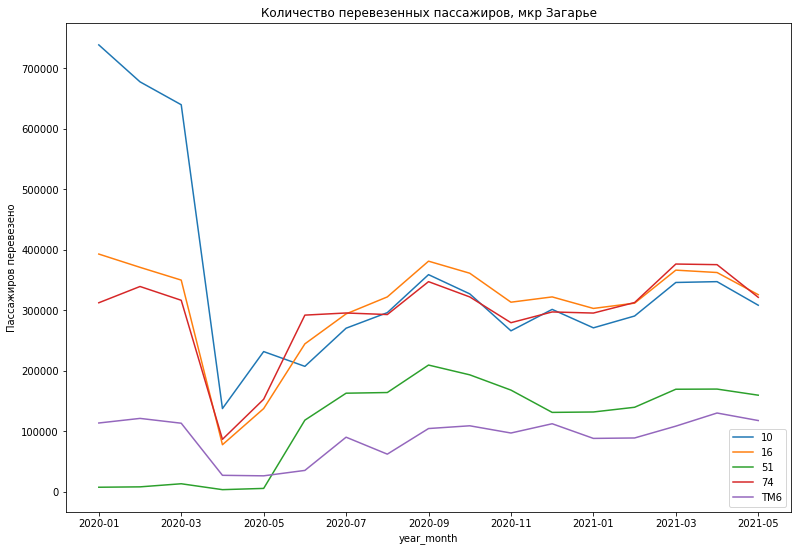

In [30]:
zagarie_routes_passengers = zagarie_routes.pivot_table(index='year_month', columns='route_number', values='count_of_passengers', aggfunc='sum')
zagarie_routes_passengers.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=[13, 9])
zagarie_routes_passengers.plot(ax=ax)
plt.title('Количество перевезенных пассажиров, мкр Загарье')
plt.ylabel('Пассажиров перевезено')
plt.legend(loc='lower right');
plt.show()

Для мкр Загарье можем говорить о том, что снижение пассажиропотока связано с сменой конечной точки 10 автобуса на Октябрьскую площадь. Появившийся как дополнение маршрут №51 (Пермь-1 - Загарье) не оттянул на себя всех тех, кто не поехал на автобусе №10.

Для остальных маршрутов видим, что пассажиропоток восстановился.

В феврале-марте 2021 на маршрутах 4, 80 и ТМ6 проводился эксперимент с бескондукторной системой оплаты проезда. Оценим динамику пассажиропотока в эти месяцы с общим трендом.

In [31]:
conductorless = ['4', '80', 'ТМ6']
conductorless_dates = ['2021-01', '2021-02', '2021-03', '2021-04']
conductorless_routes = passengers.query('route_number in @conductorless and year_month in @conductorless_dates')

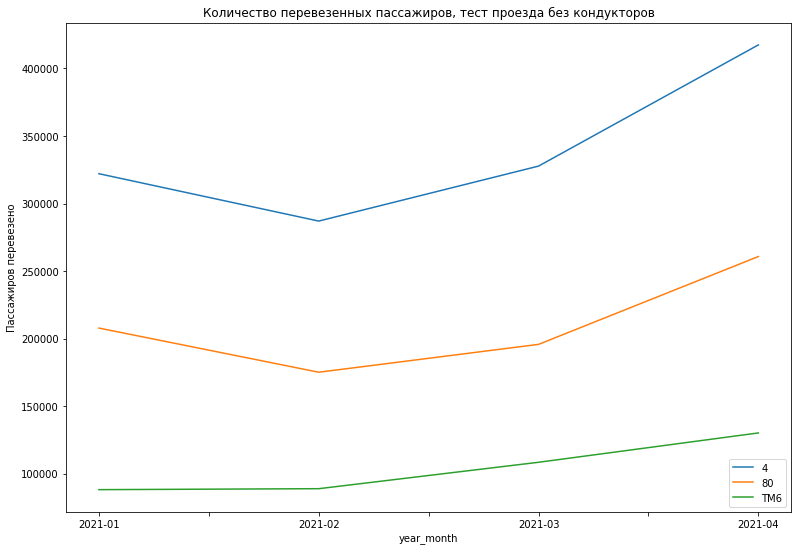

In [32]:
conductorless_routes_passengers = conductorless_routes.pivot_table(index='year_month', columns='route_number', values='passengers', aggfunc='sum')
conductorless_routes_passengers.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=[13, 9])
conductorless_routes_passengers.plot(ax=ax)
plt.title('Количество перевезенных пассажиров, тест проезда без кондукторов')
plt.ylabel('Пассажиров перевезено')
plt.legend(loc='lower right');
plt.show()

Если рассматривать все маршруты общественного транспорта, то в феврале наблюдался рост +5% к пассажиропотоку января, а в марте +20% к данным февраля.

Для автобусных маршрутов, которые ездили без кондукторов, видим снижение на 10-15% в феврале, а в марте рост и возврат примерно к показателям января. Можно говорить о том, что 15-20% пассажиров не оплачивали проезд в отсутствие кондуктора. Что ж, интересно будет посмотреть как поменяется картина в сентябре 2021, когда количество маршрутов без кондукторов увеличится.

При этом для трамвая №6 картина по пассажиропотоку в целом попадает в общий тренд. Рост в феврале и марте. Интересно, чем же отличаются пассажиры трамвая от пассажиров автобусов?

Оценим зависимость количество единиц общественного транспорта на маршруте от среднего количества пассажиров, перевозимых каждым маршрутом в месяц.

In [33]:
units_on_route = routes_by_length.groupby('route_number').agg({'passengers': 'mean'}).sort_values(by='passengers', 
                                                                                                  ascending=False)
units_on_route = units_on_route.merge(routes, how='inner', on='route_number')

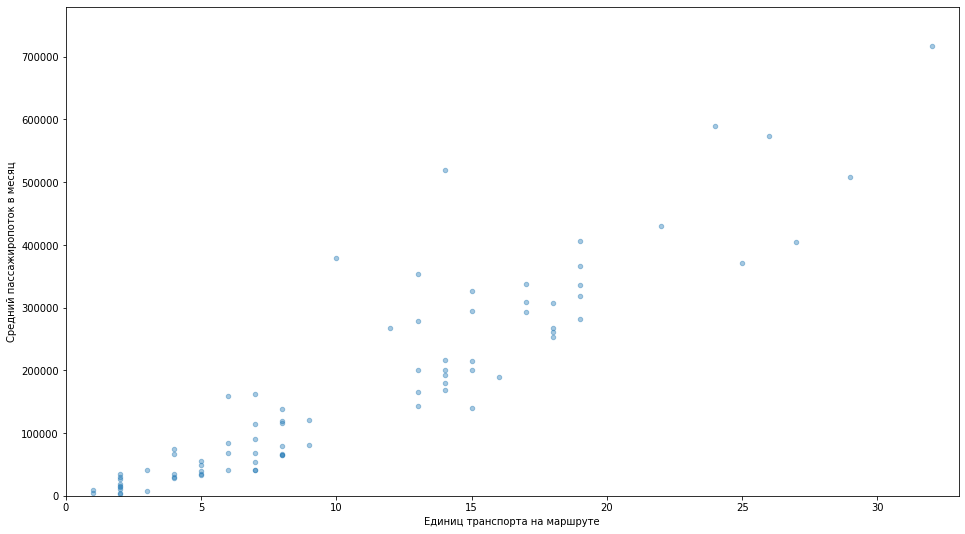

In [34]:
units_on_route.plot(x='units_quantity', y='passengers', 
               kind='scatter', alpha=0.4, 
               xlim=(0, 33), ylim=(0, 780000), 
               figsize=(16, 9))
plt.xlabel("Единиц транспорта на маршруте")
plt.ylabel("Средний пассажиропоток в месяц");

И снова респект тем, кто распределяет количество транспорта на маршрутах. Видим прямую зависимость одного показателя от другого и можем условно разделить все маршруты на три категории:
- перевозят до 200 000 пассажиров в месяц - до 10 единиц транспорта на маршруте;
- перевозят до 400 000 пассажиров в месяц - до 20 единиц транспорта на маршруте (выбивается только трамвай 11 с 14 единицами, но скорей всего добавят вагонов при открытии ветки по ул. Уральской);
- перевозят более 400 000 пассажиров - более 20 единиц транспорта на маршруте (меньше 400 000 перевозит автобус 50, выглядит как место для небольшой оптимизации, ведь длина маршрута составляет всего 10,65 км).

Таким образом результаты транспортной реформы противоречивые не только по внутренним ощущениям, но и в результате анализа данных о количестве перевезенных пассажиров. С одной стороны, пассажиропоток не восстановился, несмотря на введение бесплатных пересадок. В связи с этим наблюдаем дыру в бюджете, которая, по оценкам профильных ведомств, все растет и растет.
С другой - есть ряд решений, которые сработали хорошо, а количество техники на маршрутах коррелирует с пассажиропотоком. Это уже не говоря о том, что парк автобусов и трамваев обновлен и ездить в городском транспорте стало приятней.
Путей сведения баланса, как водится, два - увеличивать доходную часть или уменьшать издержки. Уже анонсировано масштабирование бескондукторных маршрутов, в летнеие месяцы на маршруты выходило меньше техники. С этой стороной вопроса все понятно. Будем надеяться, что для увеличения доходов есть какой-то глобальный план по возврату жителей Перми в общественный транспорт. Ведь план Б с увеличением стомости проезда можно подключить всегда.